#The Q500US and Q1500US

by Gil Wassermann and Scott Sanderson

A few weeks ago we floated a preliminary universe selection methodology that sought to greatly reduce the risk of an order not being filled in an algorithmic portfolio (https://www.quantopian.com/posts/the-tradeable500us-is-almost-here).

Today, we're releasing two complete universe implementations, the **Q500US** and the **Q1500US**, along with a suite of tools for implementing your own trading universes.

## What is the Q500US?

(**Note:** The content below also applies to the Q1500US, with appropriate substitutions of 1500 for 500.)

The Q500US is a universe of securities, implemented as a [Pipeline Filter](https://www.quantopian.com/help#quantopian_pipeline_factors_Factor) that produces a daily set of 500 stocks suitable for trading in a broad-market strategy. 

The selection algorithm for these stocks attempts to fulfill a few broad requirements:

1. Accept easily-tradeble equities.
2. Accept equities from a broad range of market sectors.
3. Don't change the set of accepted equities too much each day.

The selection algorithm is defined as follows:

    At the start of each month, throw out "hard-to-trade" equities, then choose the top 500 equities 
    by 200-day average dollar volume (ADV), choosing no more than 30% of the requested equities from
    any single sector.
    
The Q500US algorithm starts by eliminating various classes of "hard-to-trade" equities.  These include equities that are non-primary shares, stocks with missing data in the Quantopian database, stocks that only trade over-the counter (OTC), and more. See below for a full description of all the stocks initially removed.

The Q500US uses 200-day Average Dollar Volume (ADV) as its primary measure of liquidity.  This is simply the average of the product of an equity's volume and its close price over the last 200 days.

The Q500US recalculates monthly to avoid excessive turnover at the boundary of its 500-stock portfolio.  By only recalculating at the start of each month, we ensure that algorithms using the Q500US have a stable universe between calculations.

## Why do we need the Q500US?

There are two major benefits of using the Q500US or the Q1500US in an algorithm:

1. Restricting an algorithm to only trade assets accepted by the Q500US or Q1500US reduces the risk
that an order placed by the algorithm will not be filled.

2. Having a consistent universe makes it easier to compare the performance of certain classes of algorithms.  In particular, having the same initial universe is helpful for evaluating algorithms that operate by scoring assets and bucketing them into long and short portfolios.

## How do I use the Q500US?

The Q500US and Q1500US are just functions returning [Pipeline API Filters](https://www.quantshack.com/tutorials/pipeline#lesson5). You can use them anywhere you could use a normal filter.  For example, to get the close price of every asset in the Q1500US on the first trading day of 2016, we could do the following:

In [1]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.research import run_pipeline
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US

pipe = Pipeline(
    columns={'Close': USEquityPricing.close.latest},
    screen=Q1500US()
)

run_pipeline(pipe, '2016-01-02', '2016-01-02').head(20)  # head(20) shows just the first 20 rows

Close
2016-01-04 00:00:00+00:00 Equity(2 [AA])        9.86
                          Equity(24 [AAPL])   105.23
                          Equity(53 [ABMD])    90.24
                          Equity(62 [ABT])     44.91
                          Equity(67 [ADSK])    60.92
                          Equity(76 [TAP])     93.92
                          Equity(114 [ADBE])   93.91
                          Equity(122 [ADI])    55.32
                          Equity(128 [ADM])    36.67
                          Equity(161 [AEP])    58.27
                          Equity(166 [AES])     9.58
                          Equity(168 [AET])   108.12
                          Equity(185 [AFL])    59.90
                          Equity(197 [AGCO])   45.40
                          Equity(216 [HES])    48.49
                          Equity(239 [AIG])    61.97
                          Equity(266 [AJG])    40.94
                          Equity(270 [AKRX])   37.30
                          Equity(300 [ALK])    80.49
                          Equity(301 [ALKS])   79.36

## Analyzing Universe Definitions

Readers who are happy to accept these universes on faith can stop reading here and start coding up some algorithms that trade liquid securities. For those who will take a bit of convincing, keep reading.

In this section, we compare the behavior of the Q500US with two simple alternatives: choosing the top 500 stocks by market cap, and choosing the top 6% of stocks by dollar volume.

In [2]:
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import AverageDollarVolume

def calculate_example_universes(start, end):

    top_adv_6_pct = AverageDollarVolume(window_length=200).percentile_between(94, 100)
    market_cap_top_500 = morningstar.valuation.market_cap.latest.top(500)
    
    pipe = Pipeline(
        columns={
            'Top 6% ADV': top_adv_6_pct,
            'Top 500 Market Cap': market_cap_top_500,
            'Q500US': Q500US(),
        }
    )
    return run_pipeline(pipe, start, end)

In [3]:
universe_results = calculate_example_universes('2015-01-02', '2015-12-30')
universe_results.head()

Q500US Top 500 Market Cap  \
2015-01-02 00:00:00+00:00 Equity(2 [AA])       True               True   
                          Equity(21 [AAME])   False              False   
                          Equity(24 [AAPL])    True               True   
                          Equity(25 [AA_PR])  False              False   
                          Equity(31 [ABAX])   False              False   

                                             Top 6% ADV  
2015-01-02 00:00:00+00:00 Equity(2 [AA])           True  
                          Equity(21 [AAME])       False  
                          Equity(24 [AAPL])        True  
                          Equity(25 [AA_PR])      False  
                          Equity(31 [ABAX])       False

The `DataFrame.unstack()` method pivots our frame so that we just have a single row per day indicating for each `(equity, universe)` whether `equity` was accepted by `universe` on the day in question.

This is a more useful convenient representation of the data for calculating many of the visualizations below.

In [4]:
unstacked_results = universe_results.unstack().fillna(False)
unstacked_results.head()

Q500US                                      \
                          Equity(2 [AA]) Equity(21 [AAME]) Equity(24 [AAPL])   
2015-01-02 00:00:00+00:00           True             False              True   
2015-01-05 00:00:00+00:00           True             False              True   
2015-01-06 00:00:00+00:00           True             False              True   
2015-01-07 00:00:00+00:00           True             False              True   
2015-01-08 00:00:00+00:00           True             False              True   

                                                                \
                          Equity(25 [AA_PR]) Equity(31 [ABAX])   
2015-01-02 00:00:00+00:00              False             False   
2015-01-05 00:00:00+00:00              False             False   
2015-01-06 00:00:00+00:00              False             False   
2015-01-07 00:00:00+00:00              False             False   
2015-01-08 00:00:00+00:00              False             False   

                                                                               \
                          Equity(39 [DDC]) Equity(41 [ARCB]) Equity(52 [ABM])   
2015-01-02 00:00:00+00:00            False             False            False   
2015-01-05 00:00:00+00:00            False             False            False   
2015-01-06 00:00:00+00:00            False             False            False   
2015-01-07 00:00:00+00:00            False             False            False   
2015-01-08 00:00:00+00:00            False             False            False   

                                                              \
                          Equity(53 [ABMD]) Equity(62 [ABT])   
2015-01-02 00:00:00+00:00             False             True   
2015-01-05 00:00:00+00:00             False             True   
2015-01-06 00:00:00+00:00             False             True   
2015-01-07 00:00:00+00:00             False             True   
2015-01-08 00:00:00+00:00             False             True   

                                  ...                    Top 6% ADV  \
                                  ...          Equity(49682 [DYLS])   
2015-01-02 00:00:00+00:00         ...                         False   
2015-01-05 00:00:00+00:00         ...                         False   
2015-01-06 00:00:00+00:00         ...                         False   
2015-01-07 00:00:00+00:00         ...                         False   
2015-01-08 00:00:00+00:00         ...                         False   

                                                                    \
                          Equity(49683 [IMOM]) Equity(49684 [MCX])   
2015-01-02 00:00:00+00:00                False               False   
2015-01-05 00:00:00+00:00                False               False   
2015-01-06 00:00:00+00:00                False               False   
2015-01-07 00:00:00+00:00                False               False   
2015-01-08 00:00:00+00:00                False               False   

                                                                      \
                          Equity(49685 [NOK_WI]) Equity(49686 [RIV])   
2015-01-02 00:00:00+00:00                  False               False   
2015-01-05 00:00:00+00:00                  False               False   
2015-01-06 00:00:00+00:00                  False               False   
2015-01-07 00:00:00+00:00                  False               False   
2015-01-08 00:00:00+00:00                  False               False   

                                                                       \
                          Equity(49687 [RNVA_W]) Equity(49688 [UDBI])   
2015-01-02 00:00:00+00:00                  False                False   
2015-01-05 00:00:00+00:00                  False                False   
2015-01-06 00:00:00+00:00                  False                False   
2015-01-07 00:00:00+00:00                  False                False   
2015-01-08 00:00:00+00:00                  False             

### Daily Size

One desirable property of a trading universe is maintaining a consistent number of assets. 
Having a consistent size helps ensure that an algorithm doesn't waste capital by unnecessarily rebalancing its portfolio to a different target size.

In [5]:
def plot_daily_universe_size(unstacked, ylim=None):
    """Plot the number of assets accepted by each universe each day."""
    # Generate base data for the plot.
    daily_counts = (
        unstacked
        .groupby(axis=1, level=0)
        .sum()
    )
    
    # Write the data to an axis.
    ax = daily_counts.plot(figsize=(14, 8))
    
    # Add style to the axis.
    ax.grid(False)
    
    ax.set_title('Assets Accepted per Day')
    
    ax.set_ylabel('Number of Assets')
    if ylim is not None:
        ax.set_ylim(ylim)

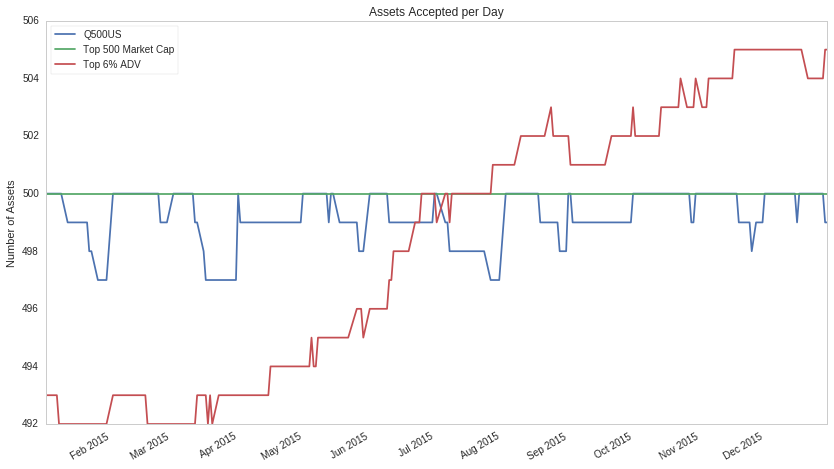

In [6]:
plot_daily_universe_size(unstacked_results)

The "Top 500 Market Cap" universe has the most stable behavior, producing exactly 500 stocks every day.

The "Top 5% ADV" universe has a clear upward trend in asset count, because the total number of known assets is increasing during this period.

The Q500 US has 500 stocks at the start of each month, but slowly loses shrinks over the course of the month as chosen stocks stop existing or become untradeable.  (In a few cases, stocks return to the universe during the month, indicating that the stock was briefly considered "hard-to-trade" during the month.)

### Daily Turnover

Another consideration when evaluating a universe is how frequently the set of accepted stocks changes.  

If the entire universe changes every day (ie, if the universe has high turnover), then an algorithm using the universe will have to sell its entire portfolio and buy an entirely new one every time it trades. These events incur transaction costs, which erode returns. 

On the other hand, if our universe never changes at all, then we won't ever trade new stocks as they become available, and we won't remove old stocks that are no longer appropriate for our algorithms.  One of the challenges of designing a universe-selection model is balancing the inherent tradeoffs between turnover and stagnation.

In [7]:
def calculate_daily_turnover(unstacked):
    return (unstacked
            .diff()        # Get True/False showing where values changed from previous day.
            .iloc[1:]      # Drop first row, which is meaningless after diff().
            .astype(bool)  # diff() coerces from bool -> object :(.  Undo that.
            .groupby(axis=1, level=0)  
            .sum())        # Group by universe and count number of True values in each row.

def plot_daily_turnover(unstacked):
    
    # Calculate locations where the inclusion state of an asset changed.
    turnover = calculate_daily_turnover(unstacked)
    
    # Write the data to an axis.
    ax = turnover.plot(figsize=(14, 8))
    
    # Add style to the axis.
    ax.grid(False)
    ax.set_title('Changes per Day')
    ax.set_ylabel('Number of Added or Removed Assets')
    

def print_daily_turnover_stats(unstacked):
    turnover = calculate_daily_turnover(unstacked)
    print(turnover.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

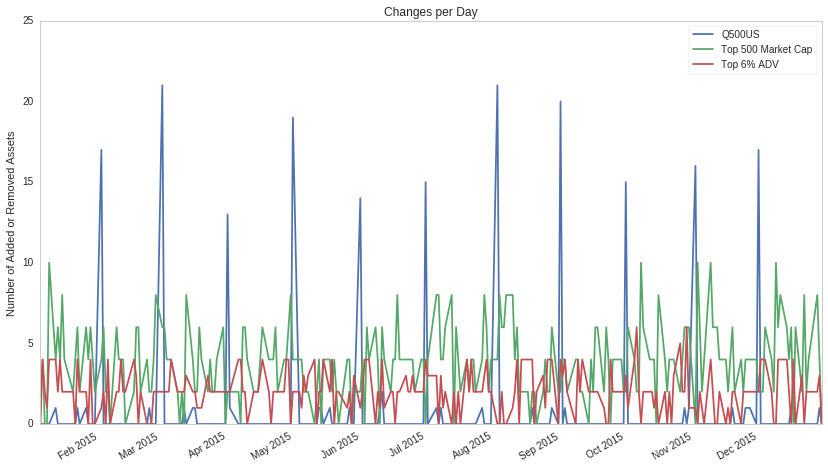

In [8]:
plot_daily_turnover(unstacked_results)

In [9]:
print_daily_turnover_stats(unstacked_results)

         Q500US  Top 500 Market Cap  Top 6% ADV
mean   0.868000            3.800000    2.024000
std    3.548088            2.254848    1.376591
25%    0.000000            2.000000    1.000000
50%    0.000000            4.000000    2.000000
75%    0.000000            6.000000    3.000000
min    0.000000            0.000000    0.000000
max   21.000000           10.000000    6.000000


The "Top 6% ADV" and "Top 500 Market Cap" universes have a modest amount of turnover each day 
(averaging about 2 and 4 stocks in/out each day, respectively).  By contrast, the Q500US concentrates all of its turnover at the start of the month, where it rotates about 15 securities in and out on average.

There is a small amount of intra-month turnover in the Q500US. This caused by stocks delisting, being acquired, or becoming "hard-to-trade" in the middle of the month. When a stock becomes "hard-to-trade" the Q500US removes it from the universe, no matter what date in the month this occurs.

### Sector Breakdown

Stocks in the same sector of the market tend to have similar risk exposures, and as such are more likely to move together in price.  Consequently, we often want to develop trading strategies that select a portfolio that's diversified across market sectors.

Let us imagine a universe where 80% of the constituents are tech stocks. Any algorithm picking stocks from this universe will have a strong sector bias, and its subsequent return stream will be very correlated to the fortunes of the tech industry.

Having all sectors represented with equal proportions has its downsides. Some sectors are not as liquid as others, so a universe that forces, communications services sector and the industrials sector to have equal representations will likely include more illiquid communications services equities at the expense of more liquid industrials equities.

For the Q500US and Q1500US, we balance these considerations by capping the proportion of the final universe that can be assigned to one sector. Here, any one sector can not represent more than 30% of the universe.

Let us have a look at the sector breakdown of the Q1500US on a single day.

In [10]:
from quantopian.pipeline.classifiers.morningstar import Sector

SECTOR_CODE_NAMES = {
    Sector.BASIC_MATERIALS: 'Basic Materials',
    Sector.CONSUMER_CYCLICAL: 'Consumer Cyclical',
    Sector.FINANCIAL_SERVICES: 'Financial Services',
    Sector.REAL_ESTATE: 'Real Estate',
    Sector.CONSUMER_DEFENSIVE: 'Consumer Defensive',
    Sector.HEALTHCARE: 'Healthcare',
    Sector.UTILITIES: 'Utilities',
    Sector.COMMUNICATION_SERVICES: 'Communication Services',
    Sector.ENERGY: 'Energy',
    Sector.INDUSTRIALS: 'Industrials',
    Sector.TECHNOLOGY: 'Technology',
}

def get_q1500_sector_codes(day):
    pipe = Pipeline(columns={'Sector': Sector()}, screen=Q1500US())
    # Drop the datetime level of the index, since we only have one day of data.
    return run_pipeline(pipe, day, day).reset_index(level=0, drop=True)


def calculate_sector_counts(sectors):
    counts = (sectors.groupby('Sector').size())

    # Replace numeric sector codes with human-friendly names.
    counts.index = counts.index.map(lambda code: SECTOR_CODE_NAMES[code])
    return counts

In [11]:
q1500_sectors = get_q1500_sector_codes('2016-01-04')
q1500_sector_counts = calculate_sector_counts(q1500_sectors)
q1500_sector_counts

Basic Materials            74
Consumer Cyclical         239
Financial Services        168
Real Estate               117
Consumer Defensive         77
Healthcare                201
Utilities                  56
Communication Services     24
Energy                    111
Industrials               209
Technology                224
dtype: int64

In [12]:
def plot_sector_counts(sector_counts):
    ax = sector_counts.plot(
        kind='pie', 
        colormap='Set3', 
        autopct='%.2f %%',
        fontsize=12,
    )
    ax.set_title('Q1500US Sector Breakdown', fontsize=18)
    ax.set_ylabel('')  # This overwrites default ylabel, which is the string None :(.

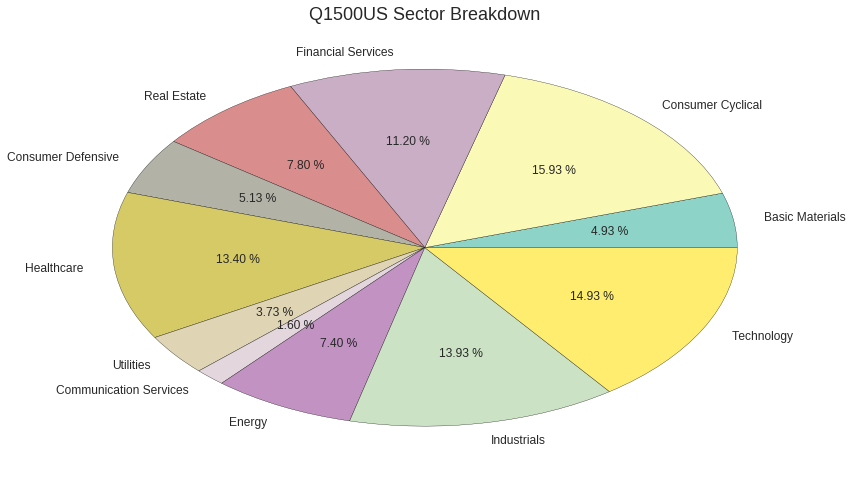

In [13]:
plot_sector_counts(q1500_sector_counts)

There are clearly some sectors that take up a larger proportion of the universe than others. However, you can see that no single sector dominates the universe. The Q500US and Q1500US guarantee this behaviour.

## Custom Universes

In the previous section, we took a look at the behavior of Quantopian's new built-in universes.  We outlined some of the considerations that go into designing a universe selection model, and we saw how the Q500US and Q1500US stack up against a few simple alternatives.

For many users the built-in universes are sufficient as starting point for building more interesting models.  More advanced users, however, may want fine-grained control over their universe construction.

In this section, we describe the underlying implementation of the Q500US and Q1500US, and we show how create your own custom universes using the same underlying machinery that powers the builtins.

At the heart of the Q500US and Q1500US is a factory function called ``make_us_equity_universe`` which implements the core universe construction logic in terms of a small number of parameters.  The Q500US and Q1500US are implemented simply as invocations of ``make_us_equity_universe`` with particular arguments.

`make_us_equity_universe` accepts the following parameters:

* **target_size**: The target number of securities the universe will accept per day.
* **rankby**: A Factor used to rank assets each day.
* **mask**: A Filter run each day that should return False for equities not wanted in the universe.
* **groupby**: A Classifier used to group assets into buckets.
* **max_group_weight**: A float in `[0.0, 1.0]` indicating the maximum percentage of assets accepted in a single bucket by `groupby`.
* **smoothing_func**: A function that takes a Filter as input and returns a new Filter.

Given these parameters, we construct a universe as follows:

1. Filter out any equities for which ```mask``` returns False
2. Partition the remaining stocks into buckets based on the labels computed by ```groupby```
3. Choose the top ``target_size`` stocks, sorted by ``rankby``, subject to the constraint that the percentage of stocks accepted in any single group in (2) is less than or equal to ``max_group_weight``.
4. Pass the resulting "naive" filter to ``smoothing_func``, which must return a new Filter.

The documentation for `make_us_equity_universe` provides a comprehensive description of the algorithm:

In [14]:
from quantopian.pipeline.filters import  make_us_equity_universe

# Executing this cell will bring up the function documentation.
make_us_equity_universe?

### Reimplementing the Q1500US as a Custom Universe

We can easily verify that the Q1500US is just a particular invocation of `make_us_equity_universe`:

In [15]:
from quantopian.pipeline.filters import default_us_equity_universe_mask

manual_Q1500US = make_us_equity_universe(
    target_size=1500,
    rankby=AverageDollarVolume(window_length=200),
    mask=default_us_equity_universe_mask(),
    groupby=Sector(),
    max_group_weight=0.3,
    smoothing_func=lambda f: f.downsample('month_start')
)

results = run_pipeline(
    Pipeline({'manual': manual_Q1500US, 'builtin': Q1500US()}),
    '2015-02', '2015-03',
)
(results['manual'] == results['builtin']).all()

True

### Example Universe Tweaks

Exposing the underlying machinery makes it easy for users to tweak the existing behavior to suit their particular needs:

In [16]:
# Get 3000 stocks instead of 500 or 1500.
Q3000US = make_us_equity_universe(
    target_size=3000,  # <---
    rankby=AverageDollarVolume(window_length=200),
    mask=default_us_equity_universe_mask(),
    groupby=Sector(),
    max_group_weight=0.3,
    smoothing_func=lambda f: f.downsample('month_start')
)

# Rank by market cap instead of dollar volume.
market_cap_universe = make_us_equity_universe(
    target_size=1500,
    rankby=morningstar.valuation.market_cap.latest,  # <---
    mask=default_us_equity_universe_mask(),
    groupby=Sector(),
    max_group_weight=0.3,
    smoothing_func=lambda f: f.downsample('month_start')
)

# Limit weight by super-sector instead of sector, capped at 50%.
from quantopian.pipeline.classifiers.morningstar import SuperSector
super_sector_weighted_universe = make_us_equity_universe(
    target_size=1500,
    rankby=AverageDollarVolume(window_length=200),
    mask=default_us_equity_universe_mask(),
    groupby=SuperSector(),  # <---
    max_group_weight=0.5,   # <---
    smoothing_func=lambda f: f.downsample('month_start')
)

# 100 stocks, equal-weighted by decile of market cap.
equal = make_us_equity_universe(
    target_size=100,
    rankby=AverageDollarVolume(window_length=200),
    mask=default_us_equity_universe_mask(),
    groupby=morningstar.valuation.market_cap.latest.deciles(),  # <---
    max_group_weight=0.1,                                       # <---
    smoothing_func=lambda f: f.downsample('month_start')
)

### Limiting Turnover: Smoothing

Controlling turnover proved to be one of trickiest aspects of creating a new universe.  We went through several iterations during development of the Q500US and Q1500US as we tried to balance the tradeoffs between responsiveness, turnover, and model complexity.

Our first implementation simply used the top 500/1500 stocks each day by trailing ADV.  We quickly learned, however, that our resulting universe changed too much day-over-day for use in an algorithm without workarounds in the algorithm's ordering logic.  Even worse, assets would often flicker in and out of the universe at the rank boundary, leading to algorithms repeatedly buying and selling the same stock as it entered and exited.

To address boundary thrashing, we added `smoothing_func` to the API, which allows the user to pass a function that transforms the naive rank-based filter.  This allows constructions like "require that an asset has passed the naive filter for N consecutive days", or "require that an asset has passed the naive filter for N of the last K days".  

These initial smoothing attempts helped, but they ultimately did not sufficiently address the thrashing problem.  Since they might still be useful in other contexts, our discarded smoothing operators have been made importable from `quantopian.pipeline.filters`.

In [17]:
from quantopian.pipeline.filters import Any, All, AtLeastN


def run_rejected_universes(start_date, end_date):
    """Run a Pipeline demonstrating discarded attempts at universe smoothing."""
    
    unsmoothed = make_us_equity_universe(
        target_size=1500,
        rankby=AverageDollarVolume(window_length=200),
        mask=default_us_equity_universe_mask(),
        groupby=Sector(),
        max_group_weight=0.3,
        smoothing_func=lambda f: f,  # No smoothing.
    )
    
    require_5_consecutive = make_us_equity_universe(
        target_size=1500,
        rankby=AverageDollarVolume(window_length=200),
        mask=default_us_equity_universe_mask(),
        groupby=Sector(),
        max_group_weight=0.3,
        smoothing_func=lambda f: All(window_length=5, inputs=[f]),
    )
    
    require_7_of_last_10 = make_us_equity_universe(
        target_size=1500,
        rankby=AverageDollarVolume(window_length=200),
        mask=default_us_equity_universe_mask(),
        groupby=Sector(),
        max_group_weight=0.3,
        smoothing_func=lambda f: AtLeastN(window_length=10, inputs=[f], N=7),
    )
    
    pipe = Pipeline({
        'unsmoothed': unsmoothed,
        '5 consecutive': require_5_consecutive, 
        '7 of 10': require_7_of_last_10,
    })
    return run_pipeline(pipe, start_date, end_date)

In [18]:
rejects = run_rejected_universes('2015', '2015-06')
unstacked_rejects = rejects.unstack().fillna(False)

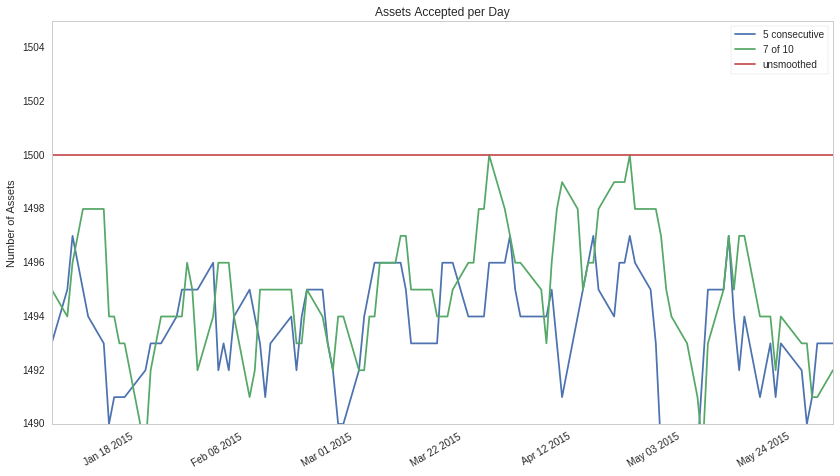

In [19]:
plot_daily_universe_size(unstacked_rejects, ylim=(1490, 1505))

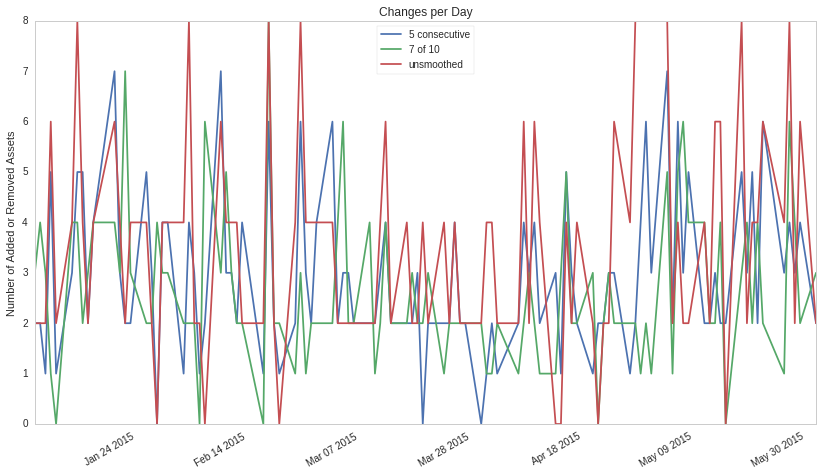

In [20]:
plot_daily_turnover(unstacked_rejects)

In [21]:
print_daily_turnover_stats(unstacked_rejects)

      5 consecutive   7 of 10  unsmoothed
mean       2.921569  2.617647    3.588235
std        1.583868  1.522401    2.167962
25%        2.000000  2.000000    2.000000
50%        3.000000  2.000000    4.000000
75%        4.000000  3.000000    4.000000
min        0.000000  0.000000    0.000000
max        7.000000  8.000000    8.000000


Both the "5 consecutive"-smoothed universe and the "7 of 10"-smoothed universe have lower average turnover than the naive universe.  Even after smoothing, however, we still have about 2 or three changes per day, and we still had cases where a stock could repeatedly enter and exit the universe in a short period of time.

### Limiting Turnover: Downsampling

A long-requested Pipeline feature has been the ability to compute Filters/Factors/Classifiers at lower-than-daily frequency.  Computing less often can be useful for two reasons:

1. When a term's `compute` method takes a very long time to run, we can trade off model accuracy for performance by computing less often.
2. When a term's `compute` method is noisy, recomputing less frequency makes the outputs more stable, which can be useful for reducing jitter in downstream consumers.

The problem of universe thrashing falls into the second category of downsampling applications.  Most rank-based selection algorithms have jitter near their acceptance threshold, and this jitter introduces significant costs for algorithms that restrict their trading to the resulting universe.  Consequently, a useful way of constraining universe turnover is to simply compute less frequently.

After our first two attempts at smoothing algorithms were less successful than desired, we decided to bite the bullet and [implement proper downsampling](https://github.com/quantopian/zipline/pull/1394) for all pipeline expressions.  As of today, all `Factors`, `Filters`, and `Classifiers`, have a new `downsample` method, which takes a string in `{'week_start', 'month_start', 'quarter_start', 'year_start'}`.  The result is a new Filter/Factor/Classifier that works by computing only at the start of a given week/month/quarter/year and forward-filling the results.

### Simple Downsampling Example

In this example, we compute and plot RSI for AAPL, downsampled to weekly, monthly, quarterly, and yearly frequency.  We choose RSI simply because it always falls between 0 and 100, which makes it easy to see the changes visually.

In [22]:
from quantopian.pipeline import CustomFilter
from quantopian.pipeline.factors import RSI

class JustAAPL(CustomFilter):
    """A Filter that only accepts AAPL"""
    inputs = ()
    window_length = 1
    AAPL_SID = 24
    
    def compute(self, today, assets, out):
        out[:] = (assets == self.AAPL_SID)


def run_downsampled_RSI_pipeline():
    rsi = RSI()
    pipe = Pipeline(
        columns={
            'weekly': rsi.downsample('week_start'),
            'monthly': rsi.downsample('month_start'),
            'quarterly': rsi.downsample('quarter_start'),
            'yearly': rsi.downsample('year_start'),
        },
        screen=JustAAPL(),
    )
    return run_pipeline(pipe, '2014', '2015-12-30')

In [23]:
import matplotlib.pyplot as plt

def plot_downsampled_results(results):
    data = results.reset_index(level=1)
    
    fig, (yearly, quarterly, monthly, weekly) = plt.subplots(4, 1, sharex=True)
    
    data['weekly'].plot(ax=weekly, ylim=(0, 100))
    weekly.set_ylabel('Weekly')
    
    data['monthly'].plot(ax=monthly, ylim=(0, 100))
    monthly.set_ylabel('Monthly')
    
    data['quarterly'].plot(ax=quarterly, ylim=(0, 100))
    quarterly.set_ylabel('Quarterly')
    
    data['yearly'].plot(ax=yearly, ylim=(0, 100))
    yearly.set_ylabel('Yearly')
    
    yearly.set_title('Downsampled AAPL RSI', fontsize=14)

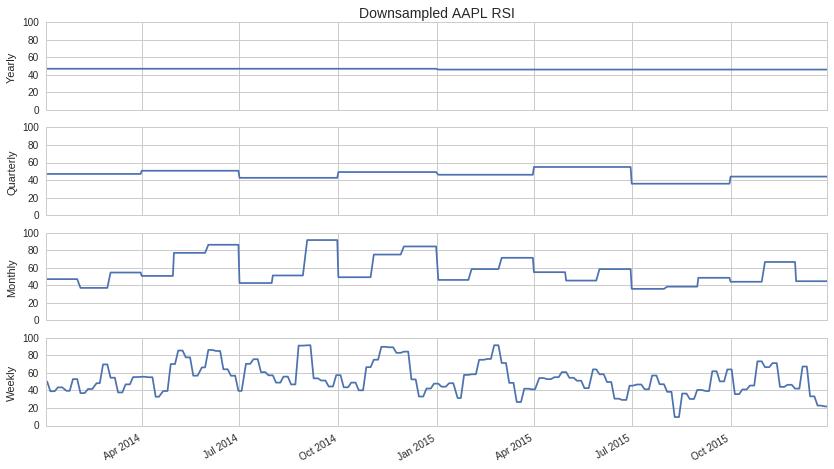

In [24]:
downsampled_results = run_downsampled_RSI_pipeline()
plot_downsampled_results(downsampled_results)

Downsampling is a powerful tool for creating stable universe selection algorithms:

In [25]:
def run_downsampled_universes():
    """Run a Q1500US at different downsampling frequencies."""
    # This is a dictionary comprehension that makes a universe using the same args as the
    # Q1500US, but downsampling at each possible frequency.
    terms = {
        freq.split('_')[0]: make_us_equity_universe(
            target_size=1500,
            rankby=AverageDollarVolume(window_length=200),
            mask=default_us_equity_universe_mask(),
            groupby=Sector(),
            max_group_weight=0.3,
            smoothing_func=lambda f: f.downsample(freq)
        )
        for freq in ('week_start', 'month_start', 'quarter_start', 'year_start')
    }
    return run_pipeline(Pipeline(terms), '2015', '2016-06')

In [26]:
downsampled_universes = run_downsampled_universes()
unstacked_downsampled_universes = downsampled_universes.unstack().fillna(False)

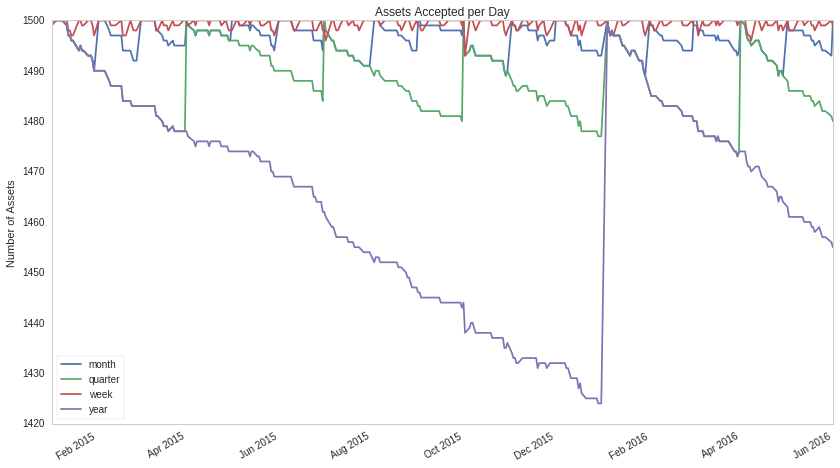

In [27]:
plot_daily_universe_size(unstacked_downsampled_universes)

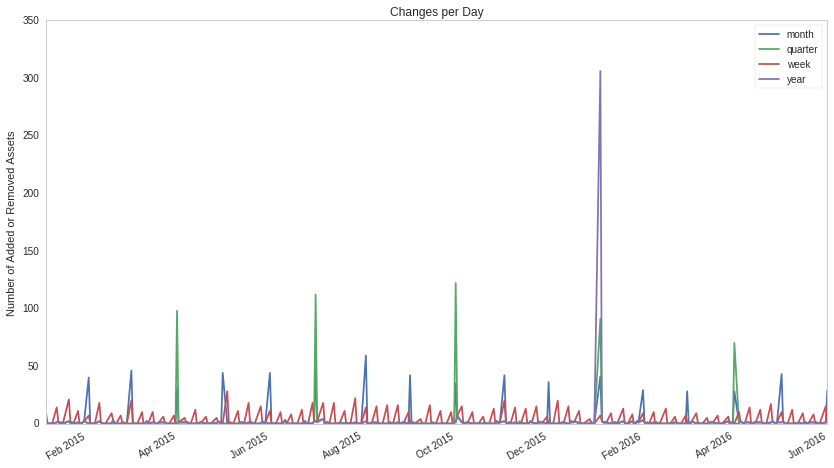

In [28]:
plot_daily_turnover(unstacked_downsampled_universes)

As you can see from these charts, when selecting a downsampling method a tradeoff has to be made. A universe that is downsampled more frequently will be more sensitive to market movements but will have a high daily turnover whereas a universe that is downsampled less freqently will exhibit a lower daily turnover but will be quite inert to market movements.

We have found that monthly downsampling provides the ideal combination of low daily turnover and good sensitivity to underlying market trends, which is why we use it in the Q500US and Q1500US.

#Going Forward

If you are developing an alpha factor, we highly recommend that you use the **Q1500US** as your starting point for universe creation. You will find the securities contained within it to be diverse enough to express many subtle opinions on the market and you will have a strong first line of defense against liquidity risk.

If you have any questions on the material in this notebook, feel free to post on this forum thread. Also, we will be releasing a lecture on universe selection soon in the Quantopian Lecture Series, so look out for that. 

*The material on this website is provided for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation or endorsement for any security or strategy, nor does it constitute an offer to provide investment advisory or other services by Quantopian.*

*In addition, the content of the website neither constitutes investment advice nor offers any opinion with respect to the suitability of any security or any specific investment. Quantopian makes no guarantees as to accuracy or completeness of the views expressed in the website. The views are subject to change, and may have become unreliable for various reasons, including changes in market conditions or economic circumstances.*